# KNN, рак и спам
__Суммарное количество баллов: 12__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[HSE][MS][ML][HW01] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

В этом домашнем задании Вам предлагается при помощи классификации методом k ближайших соседей научиться отличать тип опухоли в организме, а так же определять сообщения со спамом

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import pandas as pd
from typing import NoReturn, Tuple, List

### Задание 1 (1 балл)
Для начала работы нам необходимо научиться читать набор данных. Всего мы будем работать с двумя наборами данных.

__Cancer.csv__ - выборка данных о пациентах с доброкачественными и злокачественными опухолями. Задача - научиться их отличать.

__Spam.csv__ - набор данных большего размера. Он содержит некоторую статистику по сообщениям, а так же метку, является ли сообщение спамом. Задача - научиться автоматически отличать спам от обычных сообщений.

Реализуйте методы `read_cancer_dataset` и `read_spam_dataset`. Каждый из них принимает на вход путь к набору данных и возвращает выборку `X` и соответствующие метки `y`. Набор данных должен быть упорядочен случайно, т.е. необходимо сделать shuffle.

In [2]:
def read_cancer_dataset(path_to_csv: str) -> Tuple[np.array, np.array]:
    """
     
    Parameters
    ----------
    path_to_csv : str
        Путь к cancer датасету.

    Returns
    -------
    X : np.array
        Матрица признаков опухолей.
    y : np.array
        Вектор бинарных меток, 1 соответствует доброкачественной опухоли (M), 
        0 --- злокачественной (B).

    
    """
    df = pd.read_csv(path_to_csv) 
    df['label'] = df['label'].map({'B':0,'M':1}).astype(int)
    df = df.sample(frac=1)
    y = np.array(df['label'])
    X = np.array(df.drop('label', axis=1))
    return X, y

def read_spam_dataset(path_to_csv: str) -> Tuple[np.array, np.array]:
    """
     
    Parameters
    ----------
    path_to_csv : str
        Путь к spam датасету.

    Returns
    -------
    X : np.array
        Матрица признаков сообщений.
    y : np.array
        Вектор бинарных меток, 
        1 если сообщение содержит спам, 0 если не содержит.
    
    """
    df = pd.read_csv(path_to_csv) 
    df = df.sample(frac=1)
    y = np.array(df['label'])
    X = np.array(df.drop('label', axis=1))
    return X, y

In [3]:
read_cancer_dataset("cancer.csv")

(array([[1.176e+01, 1.814e+01, 7.500e+01, ..., 7.160e-02, 1.978e-01,
         6.915e-02],
        [1.094e+01, 1.859e+01, 7.039e+01, ..., 7.887e-02, 2.251e-01,
         7.732e-02],
        [9.268e+00, 1.287e+01, 6.149e+01, ..., 1.025e-01, 3.038e-01,
         1.252e-01],
        ...,
        [1.245e+01, 1.570e+01, 8.257e+01, ..., 1.741e-01, 3.985e-01,
         1.244e-01],
        [1.955e+01, 2.321e+01, 1.289e+02, ..., 1.825e-01, 2.576e-01,
         7.602e-02],
        [1.825e+01, 1.998e+01, 1.196e+02, ..., 1.932e-01, 3.063e-01,
         8.368e-02]]),
 array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
        1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
        1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0,
        0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1,
        1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0,
 

### Задание 2  (1 балл)
Начиная работать с данными, нам необходимо их предобработать и подготовить. В частности, нам необходимо разделить выборку на две: тренировочную и тестовую. Тренировочная выборка необходима для обучения алгоритма, а тестовая для проверки результатов обучения. Обычно используют коэффициент разделения `0.9`.

Необходимо вернуть кортеж из `X_train`, `y_train`, `X_test` и `y_test`

In [4]:
def train_test_split(X: np.array, y: np.array, ratio: float
                     ) -> Tuple[np.array, np.array, np.array, np.array]:
    """

    Parameters
    ----------
    X : np.array
        Матрица признаков.
    y : np.array
        Вектор меток.
    ratio : float
        Коэффициент разделения.

    Returns
    -------
    X_train : np.array
        Матрица признаков для train выборки.
    y_train : np.array
        Вектор меток для train выборки.
    X_test : np.array
        Матрица признаков для test выборки.
    y_test : np.array
        Вектор меток для test выборки.

    """
    assert len(X) == len(y)
    split_idx = int(len(X)*ratio)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    return X_train, y_train, X_test, y_test

### Задание 3 (2 балла)
Также прежде чем приступать к решению задачи, нам необходимо определиться с метриками, которые позволят нам оценить полученное решение. Для задач классификации мы можем использовать precision, recall и accuracy. Эти метрики считаются для каждого класса.

Метод возвращает:

* Вектор __Precision__, каждый из элементов которого равен значению метрики precision для соответствующего класса. 

* Вектор __Recall__, каждый из элементов которого равен значению метрики recall для соответствующего класса.

* __Accuracy__ - число, которое равно отношению правильно классифицированных элементов выборке к размеру выборки.

In [5]:
def get_precision_recall_accuracy(y_pred: np.array, y_true: np.array
                                  ) -> Tuple[np.array, np.array, float]:
    """

    Parameters
    ----------
    y_pred : np.array
        Вектор классов, предсказанных моделью.
    y_true : np.array
        Вектор истинных классов.

    Returns
    -------
    precision : np.array
        Вектор с precision для каждого класса.
    recall : np.array
        Вектор с recall для каждого класса.
    accuracy : float
        Значение метрики accuracy (одно для всех классов).

    """
    classes = np.unique(y_true)
    precision = np.zeros(len(classes))
    recall = np.zeros(len(classes))
    tptn = 0
    fpfn = 0
    for i, cl in enumerate(classes):
        tp = np.sum((y_true == cl) & (y_pred == cl))
        tn = np.sum((y_true != cl) & (y_pred != cl))
        fn = np.sum((y_true == cl) & (y_pred != cl))
        fp = np.sum((y_true != cl) & (y_pred == cl))
        precision[i] = tp/(tp + fp)
        recall[i] = tp/(tp + fn)
        tptn += tp + tn
        fpfn += fp + fn
    accuracy = tptn/(tptn + fpfn)
    
    return precision, recall, accuracy

Теперь, имея этот метод, мы можем построить кривые зависимости Precision, Recall и Accuracy от параметра `k`

In [6]:
def plot_precision_recall(X_train, y_train, X_test, y_test, max_k=30):
    ks = list(range(1, max_k + 1))
    classes = len(np.unique(list(y_train) + list(y_test)))
    precisions = [[] for _ in range(classes)]
    recalls = [[] for _ in range(classes)]
    accuracies = []
    for k in ks:
        classifier = KNearest(k)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        precision, recall, acc = get_precision_recall_accuracy(y_pred, y_test)
        for c in range(classes):
            precisions[c].append(precision[c])
            recalls[c].append(recall[c])
        accuracies.append(acc)
    def plot(x, ys, ylabel, legend=True):        
        plt.figure(figsize = (12, 3))
        plt.xlabel("K")
        plt.ylabel(ylabel)
        plt.xlim(x[0], x[-1])
        plt.ylim(np.min(ys)-0.01, np.max(ys)+0.01)
        for cls, cls_y in enumerate(ys):
            plt.plot(x, cls_y, label="Class " + str(cls))
        if legend:
            plt.legend()
        plt.tight_layout()
        plt.show()
    
    plot(ks, recalls, "Recall")
    plot(ks, precisions, "Precision")
    plot(ks, [accuracies], "Accuracy", legend=False)

Также для оценки качества классификации построим __ROC-кривую__. Она отражает зависимость __True Positive Rate__ (TPR) от __False Positive Rate__ (FPR) для заранее фиксированного класса. Чем график выше побочной диагонали - тем лучше.

In [7]:
def plot_roc_curve(X_train, y_train, X_test, y_test, max_k=30):
    positive_samples = sum(1 for y in y_test if y == 0)
    ks = list(range(1, max_k + 1))
    curves_tpr = []
    curves_fpr = []
    colors = []
    for k in ks:
        colors.append([k / ks[-1], 0, 1 - k / ks[-1]])
        knearest = KNearest(k)
        knearest.fit(X_train, y_train)
        p_pred = [p[0] for p in knearest.predict_proba(X_test)]
        tpr = []
        fpr = []
        for w in np.arange(-0.01, 1.02, 0.01):
            y_pred = [(0 if p > w else 1) for p in p_pred]
            tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
            fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
        curves_tpr.append(tpr)
        curves_fpr.append(fpr)
    plt.figure(figsize = (7, 7))
    for tpr, fpr, c in zip(curves_tpr, curves_fpr, colors):
        plt.plot(fpr, tpr, color=c)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

### Задание 4 (5 баллов)
Теперь преступим к реализации классификатора. В этот раз будем использовать классификацию методом k средних. Поскольку основной решаемой задачий во время классификации этим методом является поиск ближайших соседей, а набор данных может быть достаточно большим, наивная реализация будет работать очень долго.

Одним из способов решить эту проблему является __KD-дерево__. Оно позволяет значительно ускорить поиск ближайших соседей. Реализуйте построение KD-дерева и выполнение запросов на поиск k ближайших соседей.

Метод `__init__` должен принимать на вход набор точек `X`, по которому будет строиться дерево, а так же размер листов `leaf_size` построенного дерева.

Метод `query` должен принимать на вход набор точек `X`, для каждой из которых необходимо найти `k` ближайших соседей.

In [8]:
class _Node:
    def __init__(self, data: np.array, indices: np.array, left=None, right=None, dim: int = 0, leaf_size: int = 2):
        """
        Вершина дерева.
        
        Parameters
        ----------
        data : np.array
            Набор точек, по которому строится нода.
        indices: np.array
            Набор индексов для data в исходном массиве
        left: Node
            Указатель на левое поддерево
        right: Node
            Указатель на правое поддерево
        dim: int
            Размернось, по которой происходит разбиение в данной ноде.
        leaf_size : int
            Минимальный размер листа
            (то есть, пока возможно, пространство разбивается на области,
            в которых не меньше leaf_size точек).

        Returns
        -------

         """
        self.points = None
        self.indices = None
        self.median = None
        self.left = left
        self.right = right
        self._max_dim = data.shape[1]
        self.dim = dim
        self.leaf_size = leaf_size
        self._build_children(data, indices)

    def _build_children(self, data: np.array, indices: np.array):
        """
        Рекурсивно строит поддерево текущей вершины.

        Parameters
        ----------
        data : np.array
            Набор точек, по которому строится нода.
        indices: np.array
            Набор индексов для data в исходном массиве

        Returns
        -------

         """
        self.median = np.median(data[:, self.dim])
        split_mask = data[:, self.dim] < self.median
        left_data, right_data = data[split_mask], data[~split_mask]
        left_ind, right_ind = indices[split_mask], indices[~split_mask]
        if left_data.shape[0] < self.leaf_size or right_data.shape[0] < self.leaf_size:
            self.points = data
            self.indices = indices
            return
        self.left = _Node(left_data, left_ind, dim=self._next_dim())
        self.right = _Node(right_data, right_ind, dim=self._next_dim())

    def _next_dim(self) -> int:
        """
        :return:
         -------
        int
            Размерность, по которой нужно проводить разбиение в нодах на уровень ниже.
        """
        return (self.dim + 1) % self._max_dim


    def query(self, point: np.array, k: int = 1):
        """

        point: np.array
            Точка, для которой ищутся блищайшие соседи.
        k: int
            Количество ближайших соседей.
        :return:
            Список дистанций и индексов ближайших соседей.
        """
        if self.points is not None:
            distances = np.array(list(map(lambda x: np.linalg.norm(x - point), self.points)))
            mask = np.argsort(distances)
            return distances[mask][:k], self.indices[mask][:k]

        if point[self.dim] < self.median:
            distances, indices = self.left.query(point, k=k)
            if len(distances) < k or distances[-1] > np.abs(point[self.dim] - self.median):
                right_distances, right_indices = self.right.query(point, k=k)
                distances = np.hstack((distances, right_distances))
                indices = np.hstack((indices, right_indices))
        else:
            distances, indices = self.right.query(point, k=k)
            if len(distances) < k or indices[-1] > np.abs(point[self.dim] - self.median):
                left_distances, left_indices = self.left.query(point, k=k)
                distances = np.hstack((distances, left_distances))
                indices = np.hstack((indices, left_indices))

        mask = np.argsort(distances)
        return distances[mask][:k], indices[mask][:k]

class KDTree:
    def __init__(self, X: np.array, leaf_size: int = 40):
        """

        Parameters
        ----------
        X : np.array
            Набор точек, по которому строится дерево.
        leaf_size : int
            Минимальный размер листа
            (то есть, пока возможно, пространство разбивается на области,
            в которых не меньше leaf_size точек).

        Returns
        -------

        """
        self.root = _Node(X, np.array(range(X.shape[0])), leaf_size=leaf_size)

    def query(self, X: np.array, k: int = 1, return_distance: bool = False) -> List[List]:
        """

        Parameters
        ----------
        X : np.array
            Набор точек, для которых нужно найти ближайших соседей.
        k : int
            Число ближайших соседей.
        return_distance: bool
            Нужно ли возвращать дистанции до ближайших соседей.

        Returns
        -------
        list[list]
            Список списков (длина каждого списка k):
            индексы k ближайших соседей для всех точек из X.

        """
        result_indices = [[]] * X.shape[0]
        result_distances = [[]] * X.shape[0]
        for i, point in enumerate(X):
            distances, indices = self.root.query(point, k=k)
            result_indices[i] = list(indices)
            result_distances[i] = distances
        if return_distance:
            return result_distances, result_indices
        return result_indices

Поскольку данная струкутра данных является сложной, ее стоит протестировать отдельно. Для этого проведем тестирование с небольшим набором случайных точек. Если после выполнение вывод пуст, то KD-дерево скорее всего работает правильно.

In [9]:
def true_closest(X_train, X_test, k):
    result = []
    for x0 in X_test:
        bests = list(sorted([(i, np.linalg.norm(x - x0)) for i, x in enumerate(X_train)], key=lambda x: x[1]))
        bests = [i for i, d in bests]
        result.append(bests[:min(k, len(bests))])
    return result    

X_train = np.random.randn(100, 3)
X_test = np.random.randn(10, 3)
tree = KDTree(X_train, leaf_size=2)
predicted = tree.query(X_test, k=4, return_distance=False)
true = true_closest(X_train, X_test, k=4)

if np.sum(np.abs(np.array(np.array(predicted).shape) - np.array(np.array(true).shape))) != 0:
    print("Wrong shape")
else:
    errors = sum([1 for row1, row2 in zip(predicted, true) for i1, i2 in zip(row1, row2) if i1 != i2])
    if errors > 0:
        print("Encounted", errors, "errors")

### Задание 5  (3 балла)
Осталось реализовать сам классификатор. Реализуйте его, используя KD-дерево.

Метод `__init__` принимает на вход количество соседей, по которым предсказывается класс, и размер листьев KD-дерева.

Метод `fit` должен по набору данных и меток строить классификатор. 

Метод `predict_proba` должен предсказывать веротности классов для заданного набора данных основываясь на классах соседей

In [10]:
class KNearest:
    def __init__(self, n_neighbors: int = 5, leaf_size: int = 70):
        """

        Parameters
        ----------
        n_neighbors : int
            Число соседей, по которым предсказывается класс.
        leaf_size : int
            Минимальный размер листа в KD-дереве.

        """
        self.n_neighbors = n_neighbors
        self.leaf_size = leaf_size
        self.tree = None
        self.labels = None
        self.classes = None

    def fit(self, X: np.array, y: np.array) -> NoReturn:
        """

        Parameters
        ----------
        X : np.array
            Набор точек, по которым строится классификатор.
        y : np.array
            Метки точек, по которым строится классификатор.

        """
        self.tree = KDTree(X, self.leaf_size)
        self.labels = y
        self.classes = np.sort(np.unique(y))

    def predict_proba(self, X: np.array) -> List[np.array]:
        """

        Parameters
        ----------
        X : np.array
            Набор точек, для которых нужно определить класс.

        Returns
        -------
        list[np.array]
            Список np.array (длина каждого np.array равна числу классов):
            вероятности классов для каждой точки X.


        """

        neighbors_indices_list = self.tree.query(X, k=self.n_neighbors)
        result = []
        for indices in neighbors_indices_list:
            labels = self.labels[indices]
            prob = []
            for cls in self.classes:
                prob.append(np.sum(labels == cls) / self.n_neighbors)
            result.append(np.array(prob))
        return result

    def predict(self, X: np.array) -> np.array:
        """

        Parameters
        ----------
        X : np.array
            Набор точек, для которых нужно определить класс.

        Returns
        -------
        np.array
            Вектор предсказанных классов.


        """
        return np.argmax(self.predict_proba(X), axis=1)


Наконец, протестируем наш классификатор на различных наборах данных. Реализация KNearest должна отработать за разумное время.

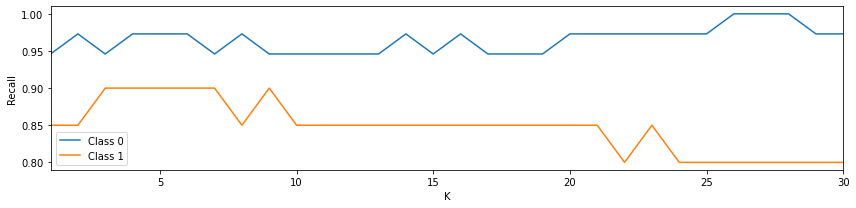

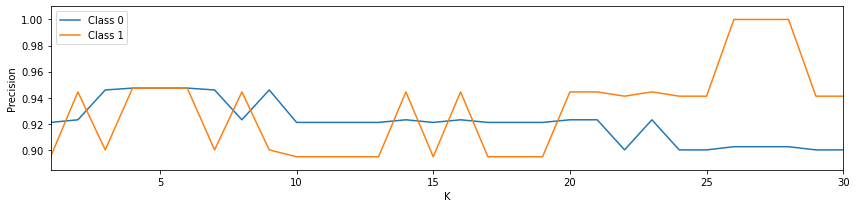

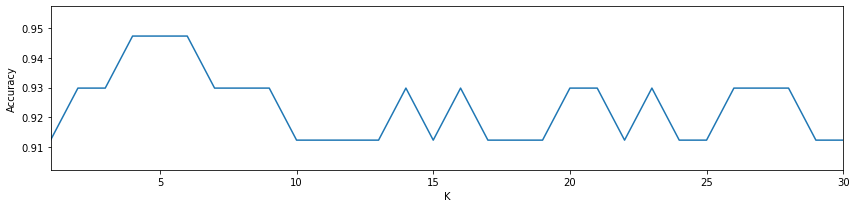

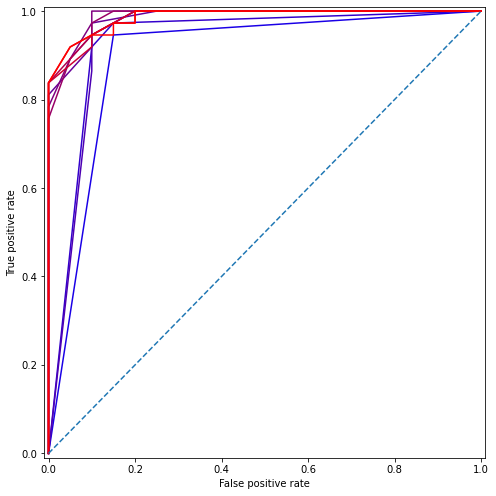

CPU times: user 19.4 s, sys: 446 ms, total: 19.9 s
Wall time: 19 s


In [11]:
%%time

X, y = read_cancer_dataset("cancer.csv")
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)
plot_precision_recall(X_train, y_train, X_test, y_test)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=10)

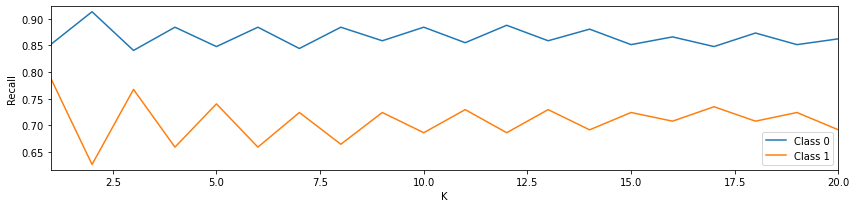

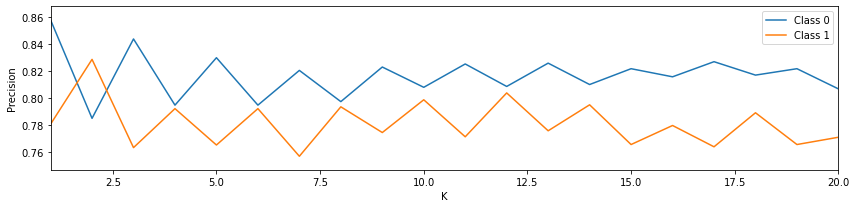

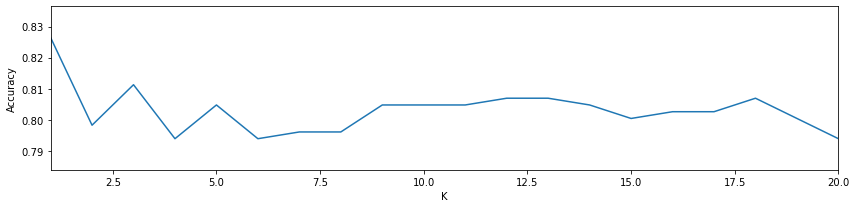

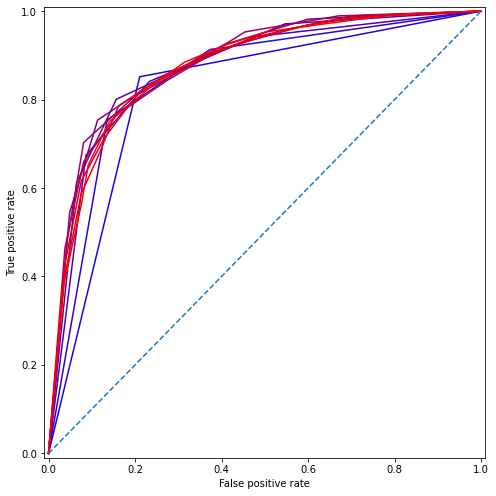

CPU times: user 6min 11s, sys: 2 s, total: 6min 13s
Wall time: 6min 12s


In [12]:
%%time

X, y = read_spam_dataset("spam.csv")
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)
plot_precision_recall(X_train, y_train, X_test, y_test, max_k=20)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=10)